# Forecasting respiratory admissions using ARIMA and Prophet

> Respiratory illnesses are **highly** seasonal.  As people with respiratory conditions are more susceptable to illness in Winter and there is a higher circulation of viruses, such as influenza, hospitals generally experience far higher demand in this period of the year.

**In this case study notebook:**

* You will work with a daily level respiratory dataset and produce an 84 day (12 week) forecast ahead.
* You will need to check that our selected method is better than a Naive benchmark.

**You will learn:**

* How to apply ARIMA and Prophet models and to select the most promising model using a holdout sample.

# Setup:

## Standard imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## forecast-tools

In [2]:
from forecast_tools.model_selection import auto_naive
from forecast_tools.metrics import coverage, mean_absolute_error

## Importing ARIMA and Prophet

In [3]:
# arima
from pmdarima import auto_arima, ARIMA
import pmdarima as pm

#should be version 1.6.0
pm.__version__

'1.6.0'

In [4]:
# prophet 
from prophet import Prophet
import prophet

#should be version 1.0+
prophet.__version__

'0.6'

# Exercise 1: load and train test split respiratory admissions daily dataset

The first split we will do in summer 2018.  Exercuise 4 will look at a winter split.

**Task:**

* Load the `resp_admissions.csv` dataset
* Use the `date` column as your DateTimeIndex
* Perform a train-test split holding back 84 days of data as a test set.
* Plot the training data
* Perform a seasonal decomposition

In [6]:
#example solution

admits = pd.read_csv('../../hds_data/resp_admissions.csv', parse_dates=True, 
                     index_col='date', dayfirst=True, dtype=np.uint8)

admits.index.freq = 'D'

In [7]:
admits.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2015-08-01 to 2018-07-30
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   resp_admits  1095 non-null   uint8
dtypes: uint8(1)
memory usage: 9.6 KB


In [8]:
# train test split
holdout = 84
training_length = len(admits) - holdout

train = admits.iloc[:training_length]
test = admits.iloc[training_length:]

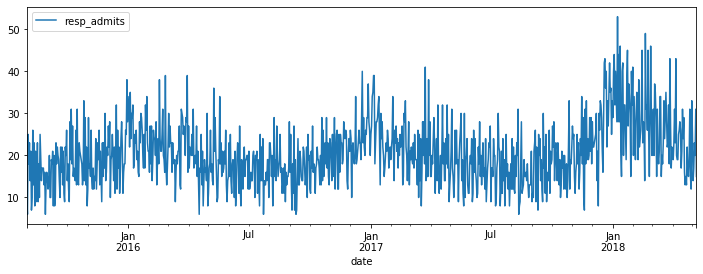

In [9]:
train.plot(figsize=(12,4))

# Exercise 2: Select a Naive forecasting benchmark

**Task:** 
    
* Select a Naive method to serve as a benchmark for ARIMA and Prophet.
* Using a simple holdout sample calculate the MAE

In [10]:
# your code here ...

In [11]:
naive_model = auto_naive(train, seasonal_period=7)
naive_model

{'model': SNaive1(period=7), 'mae': 5.394658753709199}

In [12]:
naive_preds = naive_model['model'].fit_predict(train, horizon=len(test))
mean_absolute_error(naive_preds, test)

6.921768707482993

# Exercise 3: Modelling the series using an ARIMA 

Let's first model the series using an autoARIMA model.

## Exercise 3.1. Use `auto_arima` to select ARIMA parameters

**Task**:

* Select and fit an ARIMA model.
* What model was selected?

In [13]:
#your code here ...

In [14]:
# example solution

# search for best model using auto_arima
# arima_model = auto_arima(train, m=7, suppress_warnings=True)

# best model = (3, 1, 2)(1, 0, 1, 7)
arima_model = ARIMA(order=(3, 1, 2), seasonal_order=(1, 0, 1, 7), 
                    suppress_warnings=True)
arima_model.fit(train)

ARIMA(order=(3, 1, 2), seasonal_order=(1, 0, 1, 7), suppress_warnings=True)

In [15]:
# take a look at the best model.

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1011
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -3094.316
Date:                             Mon, 10 Aug 2020   AIC                           6206.633
Time:                                     15:08:13   BIC                           6250.892
Sample:                                          0   HQIC                          6223.446
                                            - 1011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.385      0.700      -0.000       0.001
ar.L1         -0.5329      0.237     -2.246      0.025      -0.998      -0.068
ar.L2         -0.0831      0.041     -2.004      0.045      -0.164      -0.002
ar.L3         -0.1072      0.034     -3.124      0.002      -0.174      -0.040
ma.L1         -0.3604      0.240     -1.503      0.133      -0.830       0.110
ma.L2         -0.4181      0.215     -1.943      0.052      -0.840       0.004
ar.S.L7        0.9994      0.001   1757.398      0.000       0.998       1.000
ma.S.L7       -0.9724      0.010    -96.553      0.000      -0.992      -0.953
sigma2        25.7607      1.006     25.601      0.000      23.788      27.733
===================================================================================
Ljung-Box (Q):                       37.95   Jarque-Bera (JB):                29.98
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Exercise 3.2 Use the ARIMA model to predict the test set in summer

**Task**:
   
* Use your preferred ARIMA model to predict 84 days ahead
* Produce a mean point forecast and a 95% prediction interval
* Plot the predictions
* Calculate the Mean Absolute Error of the prediction.
* Calculate the Prediction Interval Coverage

In [16]:
#your code here ...

In [17]:
h = 84
forecast = arima_model.predict(n_periods=h, alpha=0.05, return_conf_int=True)
forecast = pd.concat([pd.DataFrame(forecast[0]), pd.DataFrame(forecast[1])], 
                     axis=1)
forecast.columns=['mean', 'lower_95', 'upper_95']
idx = pd.date_range(start=train.index[-1], periods=h+1, freq='D')[1:]
forecast.index = idx
forecast

,mean,lower_95,upper_95
2018-05-08,21.126985,11.179114,31.074857
2018-05-09,25.769594,15.765233,35.773956
2018-05-10,20.675472,10.638272,30.712672
2018-05-11,23.991201,13.935091,34.047311
2018-05-12,16.322668,6.124907,26.520429
...,...,...,...
2018-07-26,19.207115,2.650862,35.763368
2018-07-27,24.261359,7.624178,40.898540
2018-07-28,15.909172,-0.811312,32.629656
2018-07-29,15.406129,-1.395893,32.208151


/home/tom/anaconda3/envs/hds_forecast/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f588842a250> has a label of '_ignore' which cannot be automatically added to the legend.


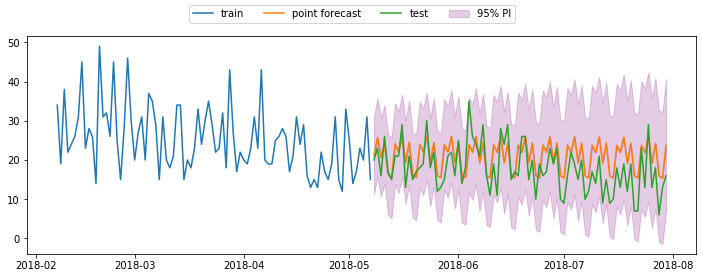

In [18]:
# plot the mean forecast and 95% prediction interval

fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(train['resp_admits'].iloc[-90:])
ax.plot(forecast['mean'])
ax.plot(test['resp_admits'])

ax.fill_between(forecast.index, forecast['mean'], forecast['upper_95'],
                alpha=0.2,
                label='95% PI', color='purple');

ax.fill_between(forecast.index, forecast['mean'], forecast['lower_95'],
                alpha=0.2,
                label='95% PI', color='purple');

fig.legend(['train', 'point forecast', 'test', '_ignore', '95% PI'], 
           loc='upper center', ncol=4);

In [19]:
# Calculate MAE

from pmdarima.metrics import smape

rmse_arima = mean_absolute_error(forecast['mean'], test['resp_admits'])
smape_arima = smape(forecast['mean'], test['resp_admits'])

print(rmse_arima)
print(smape_arima)

4.47097117844633
25.42540079598573


# Exercise 4: Predict the time series using Prophet

## Exercise 4.1: Wrangle the data into Prophet format

Prophet requires the data to be in a `pd.DataFrame` with two columns: `ds` for date and `y` for the observations.

**Task**: 

* Create a new `pd.DataFrame` for the respiratory admissions data.  
* The data should be in the format suitable for `Prophet` models.

**Hints:**
* Create a copy of your original data
* It might be useful to write a function to do the formatting.  This means you can easily reuse your code in the future.


In [20]:
# your code here ...

In [21]:
def prophet_formatted_df(df):
    '''
    Convert a pd.DataFrame with a DateTimeIndex into a prophet
    formatted dataframe
    
    Returns:
    ------
    pd.DataFrame[['ds', 'y']]
    '''
    df_prophet = df.copy()
    df_prophet = df_prophet.reset_index()
    df_prophet.columns = ['ds', 'y']
    return df_prophet
    
    

In [22]:
train_proph = prophet_formatted_df(train)
train_proph.head()

,ds,y
0,2015-08-01,9
1,2015-08-02,6
2,2015-08-03,25
3,2015-08-04,18
4,2015-08-05,23


# Exercise 4.2: Fit and predict with the prophet model

**Task**:
    
* Fit a `Prophet` model. (do not worry about holidays)
* The `interval_width` should be 0.95
* Predict 84 days into he future.
* Plot the components and the forecast
* Calculate the MAE of the Forecast
* Calculate the Prediction Interval Coverage

**Questions:**
* Do you think Prophet offers anything over and above the ARIMA model in this instance?
* If so what are concepts within Prophet that help?

In [23]:
#your code here ...

In [24]:
# example solution

h = 84
model = Prophet(interval_width=0.95)
model.fit(train_proph)
future = model.make_future_dataframe(periods=h)
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1090,2018-07-26,26.156599,11.612728,30.298547,26.034903,26.267979,-5.325272,-5.325272,-5.325272,-1.618618,-1.618618,-1.618618,-3.706654,-3.706654,-3.706654,0.0,0.0,0.0,20.831327
1091,2018-07-27,26.172679,16.884330,35.995098,26.049080,26.285338,0.235034,0.235034,0.235034,3.852000,3.852000,3.852000,-3.616966,-3.616966,-3.616966,0.0,0.0,0.0,26.407713
1092,2018-07-28,26.188758,8.147710,26.779456,26.063233,26.304656,-8.832082,-8.832082,-8.832082,-5.310274,-5.310274,-5.310274,-3.521808,-3.521808,-3.521808,0.0,0.0,0.0,17.356676
1093,2018-07-29,26.204837,8.638187,26.975049,26.077380,26.322824,-8.418658,-8.418658,-8.418658,-4.994883,-4.994883,-4.994883,-3.423774,-3.423774,-3.423774,0.0,0.0,0.0,17.786180
1094,2018-07-30,26.220917,16.589682,35.959505,26.088845,26.340943,-0.323096,-0.323096,-0.323096,3.002409,3.002409,3.002409,-3.325505,-3.325505,-3.325505,0.0,0.0,0.0,25.897821


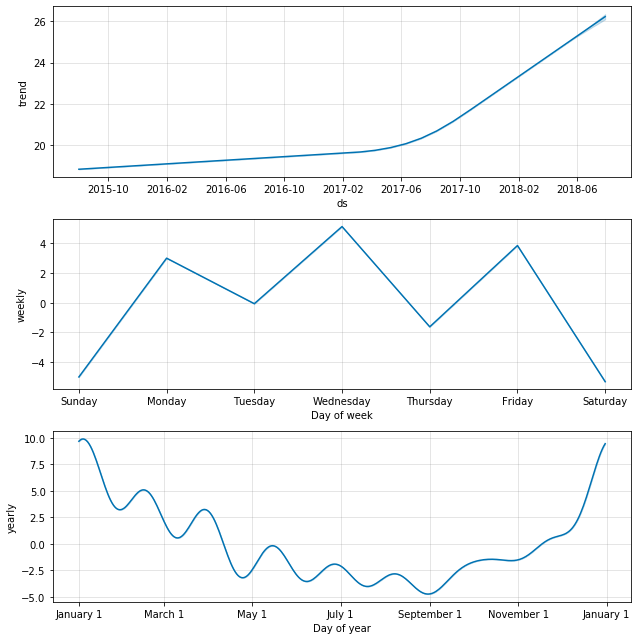

In [26]:
fig2 = model.plot_components(forecast)

/home/tom/anaconda3/envs/hds_forecast/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f5845d9ef90> has a label of '_ignore' which cannot be automatically added to the legend.


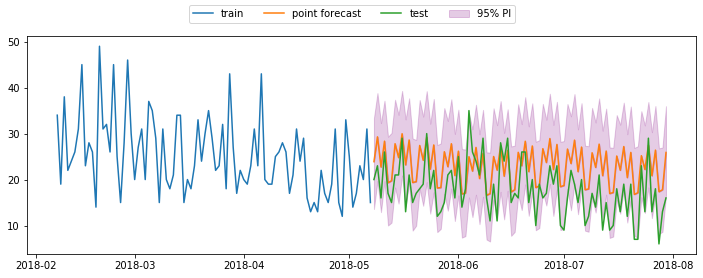

In [27]:
#plot the mean forecast and 95% prediction interval
f = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-h:]
f.index = f['ds']
f.index.freq = 'D'
#f.drop(['ds'], inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(train['resp_admits'].iloc[-90:])
ax.plot(f['yhat'])
ax.plot(test['resp_admits'].iloc[:h])

ax.fill_between(f.index, f['yhat'], f['yhat_upper'],
                alpha=0.2,
                label='95% PI', color='purple');

ax.fill_between(f.index, f['yhat'], f['yhat_lower'],
                alpha=0.2,
                label='95% PI', color='purple');

fig.legend(['train', 'point forecast', 'test', '_ignore', '95% PI'], 
           loc='upper center', ncol=4);

In [28]:
rmse_arima = mean_absolute_error(f['yhat'], test['resp_admits'].iloc[:h])
smape_arima = smape(f['yhat'], test['resp_admits'].iloc[:h])

print(rmse_arima)
print(smape_arima)

5.902301559497247
31.826163759342233


# Exercise 5: Forecasting just before the start of Winter

Now let's assume we need to make a forecast from just before the onset of winter.

**Task:**

* Train test split using a holdout sample of 245 days (test will begin from late November 2017).
* Fit an ARIMA(1, 0, 2)x(1, 0, 1, 7) and a Prophet model to the data.
* Make a 84 day prediction.  
* Include 95% prediction intervals
* Plot the results.
* Calculate MAE and Coverage for each forecast at 7 day intervals up to 84 days.  I.e. 7, 14, 28, ..., 84 

**Hints:**
* The ARIMA model was selected using `auto_arima`.  Feel free to check or try a different model. One option would be difference the time series.

**Questions**:
* What would you say the key differences between the models are?
* Which forecast method would you choose and why?
* How do the forecasts compare to a Naive model?

In [29]:
# your code goes here ...

In [30]:
# example solution

#train test split
holdout = 245
training_length = len(admits) - holdout

train = admits.iloc[:training_length]
test = admits.iloc[training_length:]
train.tail()

,resp_admits
date,
2017-11-23,19
2017-11-24,24
2017-11-25,19
2017-11-26,20
2017-11-27,29


In [31]:
#ARIMA

#auto select via AIC
#arima_model = auto_arima(train, m=7, suppress_warnings=True, 
#                         error_action="ignore")

arima_model = ARIMA(order=(1,0,2), seasonal_order=(1, 0, 1, 7), 
                    suppress_warnings=True)
arima_model.fit(train)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  850
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -2528.929
Date:                             Mon, 10 Aug 2020   AIC                           5071.858
Time:                                     15:08:18   BIC                           5105.074
Sample:                                          0   HQIC                          5084.581
                                             - 850                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0085      0.006      1.343      0.179      -0.004       0.021
ar.L1          0.8888      0.038     23.565      0.000       0.815       0.963
ma.L1         -0.7092      0.053    -13.299      0.000      -0.814      -0.605
ma.L2          0.0051      0.039      0.131      0.896      -0.071       0.082
ar.S.L7        0.9959      0.002    412.339      0.000       0.991       1.001
ma.S.L7       -0.9455      0.016    -58.594      0.000      -0.977      -0.914
sigma2        22.1361      1.062     20.849      0.000      20.055      24.217
===================================================================================
Ljung-Box (Q):                       61.61   Jarque-Bera (JB):                21.66
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.37
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
h = 84
arima_forecast = arima_model.predict(n_periods=h, alpha=0.05, return_conf_int=True)
arima_forecast = pd.concat([pd.DataFrame(arima_forecast[0]), 
                            pd.DataFrame(arima_forecast[1])], 
                            axis=1)
arima_forecast.columns=['mean', 'lower_95', 'upper_95']
idx = pd.date_range(start=train.index[-1], periods=h+1, freq='D')[1:]
arima_forecast.index = idx
arima_forecast.head()

,mean,lower_95,upper_95
2017-11-28,21.364453,12.143017,30.585889
2017-11-29,27.278043,17.909131,36.646956
2017-11-30,19.869519,10.378338,29.360701
2017-12-01,24.605615,15.018956,34.192273
2017-12-02,15.634674,5.973266,25.296082


In [33]:
train_proph = prophet_formatted_df(train)

h = 84
model = Prophet(interval_width=0.95)
model.fit(train_proph)
future = model.make_future_dataframe(periods=h)
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/home/tom/anaconda3/envs/hds_forecast/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f5845c0e450> has a label of '_ignore' which cannot be automatically added to the legend.


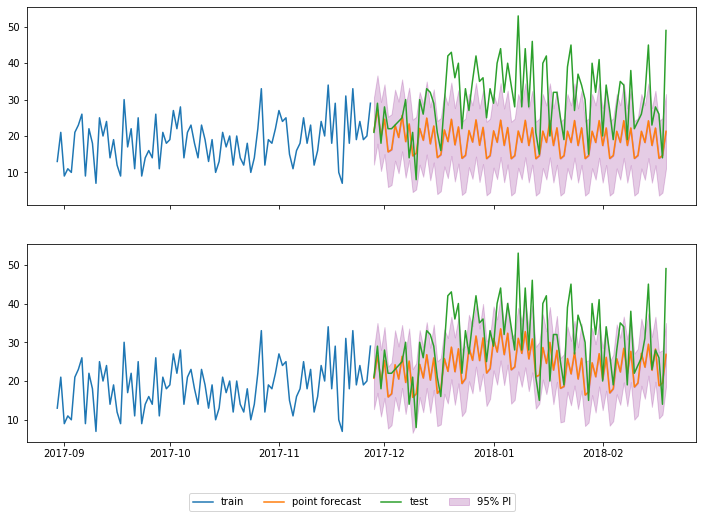

In [34]:
#plot the mean forecast and 95% prediction interval
f = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-h:]
f.index = f['ds']
f.index.freq = 'D'
#f.drop(['ds'], inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

#plot ARIMA
ax[0].plot(train['resp_admits'].iloc[-90:])
ax[0].plot(arima_forecast['mean'])
ax[0].plot(test['resp_admits'].iloc[:h])

ax[0].fill_between(arima_forecast.index, arima_forecast['mean'], 
                   arima_forecast['upper_95'],
                   alpha=0.2,
                   label='95% PI', color='purple');

ax[0].fill_between(arima_forecast.index, 
                   arima_forecast['mean'], 
                   arima_forecast['lower_95'],
                   alpha=0.2,
                   label='95% PI', color='purple');

#plot Prophet
ax[1].plot(train['resp_admits'].iloc[-90:])
ax[1].plot(f['yhat'])
ax[1].plot(test['resp_admits'].iloc[:h])

ax[1].fill_between(f.index, f['yhat'], f['yhat_upper'],
                alpha=0.2,
                label='95% PI', color='purple');

ax[1].fill_between(f.index, f['yhat'], f['yhat_lower'],
                alpha=0.2,
                label='95% PI', color='purple');


fig.legend(['train', 'point forecast', 'test', '_ignore', '95% PI'], 
           loc='lower center', ncol=4);

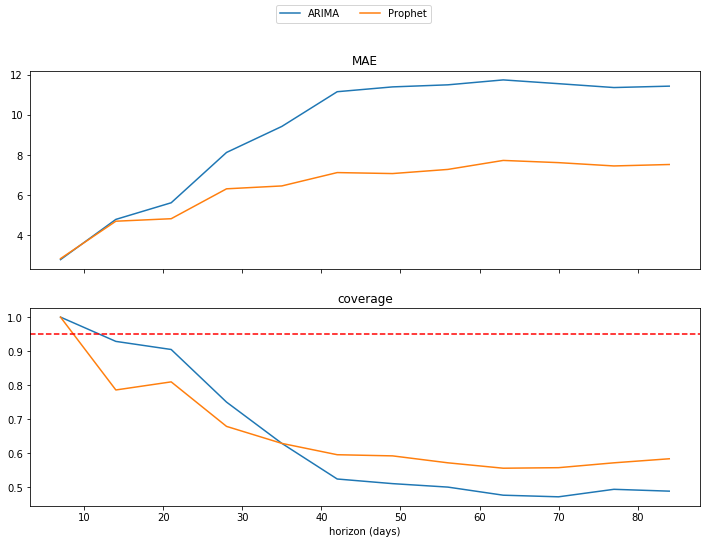

In [35]:
#calculate MAE and coverage at 7 days intervals during forecast period.
h = 84
horizons = [i for i in range(7, h+7, 7)]

arima_results = []
prophet_results = []

arima_coverage = []
prophet_coverage = []

for h in horizons:
    #mae
    m1_mae = mean_absolute_error(arima_forecast['mean'].iloc[:h], 
                                 test['resp_admits'].iloc[:h])
    m2_mae = mean_absolute_error(f['yhat'].iloc[:h], 
                                 test['resp_admits'].iloc[:h])
    
    #coverage
    m1_cov = coverage(test['resp_admits'].iloc[:h], 
                      arima_forecast[['lower_95', 'upper_95']].iloc[:h].to_numpy())
    
    m2_cov = coverage(test['resp_admits'].iloc[:h], 
                      f[['yhat_lower', 'yhat_upper']].iloc[:h].to_numpy())
    
    arima_results.append(m1_mae)
    prophet_results.append(m2_mae)
    
    arima_coverage.append(m1_cov)
    prophet_coverage.append(m2_cov)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(horizons, arima_results, label='ARIMA')
ax[0].plot(horizons, prophet_results, label='Prophet')

ax[0].set_title('MAE')

ax[1].plot(horizons, arima_coverage, label='ARIMA')
ax[1].plot(horizons, prophet_coverage, label='Prophet')
ax[1].axhline(y=0.95, color='r', linestyle='--')

ax[1].set_xlabel('horizon (days)')
ax[1].set_title('coverage')
fig.legend(['ARIMA', 'Prophet'], ncol=2, loc='upper center')

# Exercise 5: Adding in holidays to Prophet

**Task:**

* Add in Prophet's default holidays to test and refit the model
* Explore the impact of holidays.
* Use MAE and Coverage to compare the performance to the original version.


**Hints:**

* Prophet has built in routines to help.

```python
model.add_country_holidays(country_name='England')
```

**Questions**
* Do you need all of the UK holidays?
* Do the holiday effects make sense in the different seasons?
* Is there a big impact on forecasting performance overall or is limited to the holidays?

In [36]:
#your code here...

In [37]:
#example solution

train_proph = prophet_formatted_df(train)

h = 84
model = Prophet(interval_width=0.95, changepoint_prior_scale=0.3)
model.add_country_holidays(country_name='England')
model.fit(train_proph)
future_with_holidays = model.make_future_dataframe(periods=h)
forecast_holidays = model.predict(future_with_holidays)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
#these are the holidays included by default
model.train_holiday_names.to_list()

["New Year's Day",
 'Good Friday',
 'Easter Monday',
 'May Day',
 'Spring Bank Holiday',
 'Late Summer Bank Holiday',
 'Christmas Day',
 'Christmas Day (Observed)',
 'Boxing Day',
 "New Year's Day (Observed)",
 'Boxing Day (Observed)']

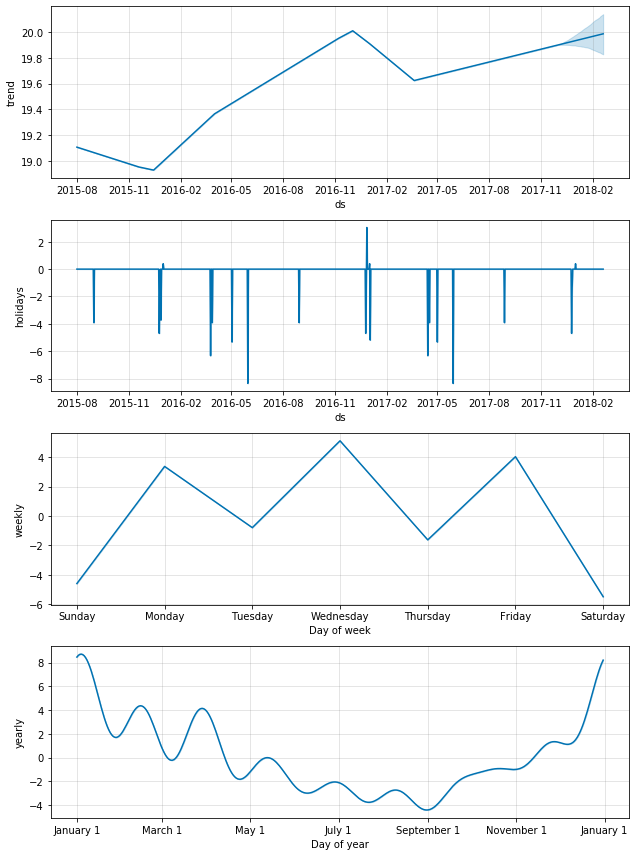

In [39]:
model.plot_components(forecast_holidays);

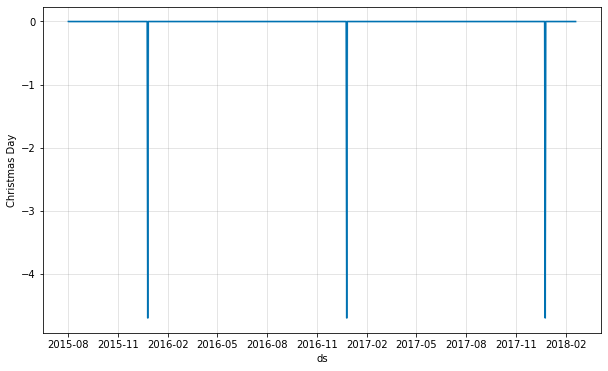

In [40]:
from fbprophet.plot import plot_forecast_component

#christmas day
plot_forecast_component(model, forecast_holidays, 'Christmas Day');

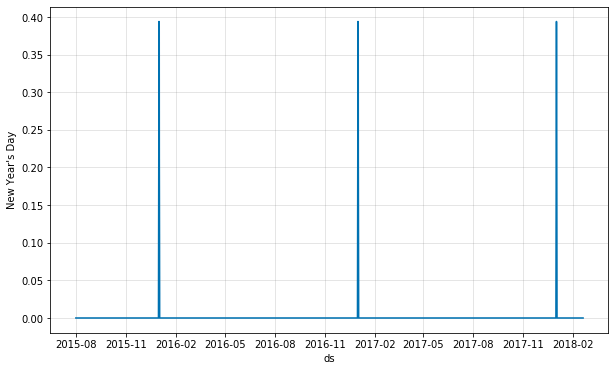

In [41]:
#New Year's Day - probably not useful
plot_forecast_component(model, forecast_holidays, "New Year's Day");

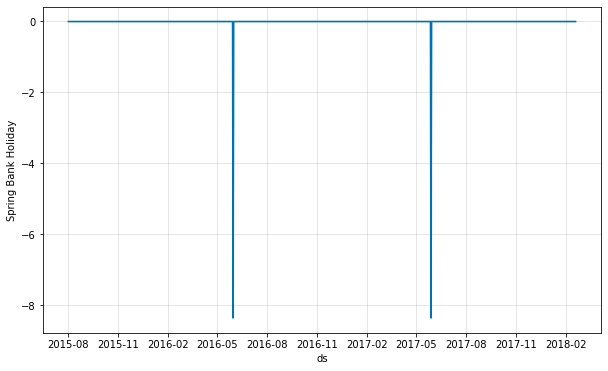

In [42]:
plot_forecast_component(model, forecast_holidays, "Spring Bank Holiday");

/home/tom/anaconda3/envs/hds_forecast/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f584592f750> has a label of '_ignore' which cannot be automatically added to the legend.


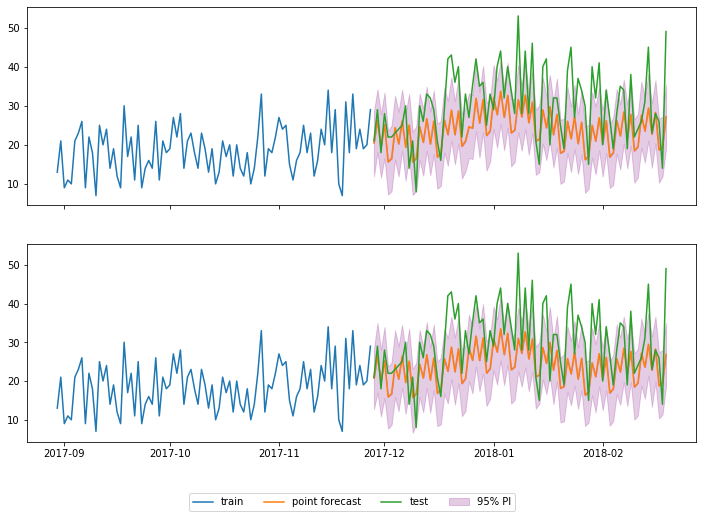

In [43]:
#plot the mean forecast and 95% prediction interval

#just predictions
f2 = forecast_holidays[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-h:]
f2.index = f2['ds']
f2.index.freq = 'D'
#f.drop(['ds'], inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

#plot Prophet with holidays
ax[0].plot(train['resp_admits'].iloc[-90:])
ax[0].plot(f2['yhat'])
ax[0].plot(test['resp_admits'].iloc[:h])

ax[0].fill_between(f2.index, f2['yhat'], f2['yhat_upper'],
                alpha=0.2,
                label='95% PI', color='purple');

ax[0].fill_between(f2.index, f2['yhat'], f2['yhat_lower'],
                alpha=0.2,
                label='95% PI', color='purple');



#plot Prophet 
ax[1].plot(train['resp_admits'].iloc[-90:])
ax[1].plot(f['yhat'])
ax[1].plot(test['resp_admits'].iloc[:h])

ax[1].fill_between(f.index, f['yhat'], f['yhat_upper'],
                alpha=0.2,
                label='95% PI', color='purple');

ax[1].fill_between(f.index, f['yhat'], f['yhat_lower'],
                alpha=0.2,
                label='95% PI', color='purple');


fig.legend(['train', 'point forecast', 'test', '_ignore', '95% PI'], 
           loc='lower center', ncol=4);

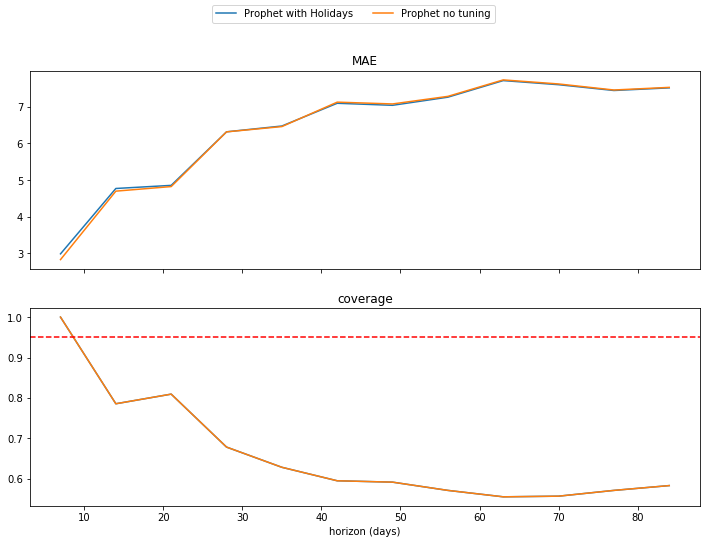

In [44]:
#calculate MAE and coverage at 7 days intervals during forecast period.
h = 84
horizons = [i for i in range(7, h+7, 7)]

holiday_results = []
prophet_results = []

holiday_coverage = []
prophet_coverage = []

for h in horizons:
    #rmse
    m1_mae = mean_absolute_error(f2['yhat'].iloc[:h], 
                                 test['resp_admits'].iloc[:h])
    m2_mae = mean_absolute_error(f['yhat'].iloc[:h], 
                                 test['resp_admits'].iloc[:h])
    
    #coverage
    m1_cov = coverage(test['resp_admits'].iloc[:h], 
                      f2[['yhat_lower', 'yhat_upper']].iloc[:h].to_numpy())
    
    m2_cov = coverage(test['resp_admits'].iloc[:h], 
                      f[['yhat_lower', 'yhat_upper']].iloc[:h].to_numpy())
    
    holiday_results.append(m1_mae)
    prophet_results.append(m2_mae)
    
    holiday_coverage.append(m1_cov)
    prophet_coverage.append(m2_cov)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(horizons, holiday_results, label='ARIMA')
ax[0].plot(horizons, prophet_results, label='Prophet')

ax[0].set_title('MAE')

ax[1].plot(horizons, prophet_coverage, label='ARIMA')
ax[1].plot(horizons, prophet_coverage, label='Prophet')
ax[1].axhline(y=0.95, color='r', linestyle='--')

ax[1].set_xlabel('horizon (days)')
ax[1].set_title('coverage')
fig.legend(['Prophet with Holidays', 'Prophet no tuning'], 
           ncol=2, loc='upper center')

# Exercise 6: Forecasting respiratory admissions

**Task**
* Using all of the data and your selected model create a 84 day forecast.

In [45]:
# your code here ...

In [46]:
train_proph = prophet_formatted_df(admits)

h = 84
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='England')
model.fit(train_proph)
future = model.make_future_dataframe(periods=h)
final_forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


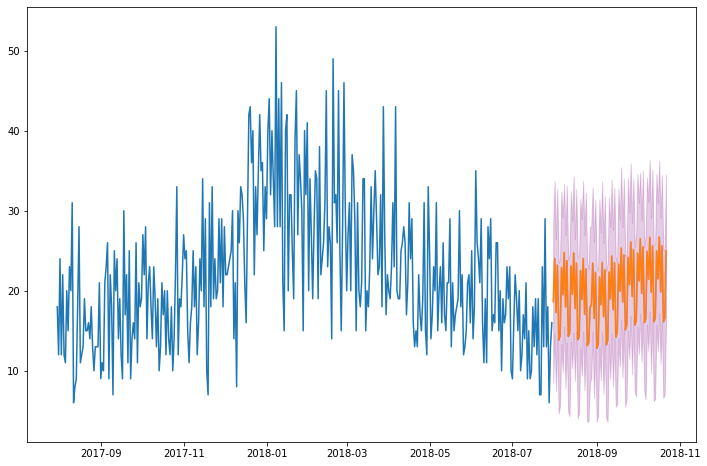

In [47]:
#plot the mean forecast and 95% prediction interval

#just predictions
f3 = final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-h:]
f3.index = f3['ds']
f3.index.freq = 'D'


fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True)

#plot Prophet with holidays
ax.plot(admits['resp_admits'].iloc[-365:])
ax.plot(f3['yhat'])

ax.fill_between(f3.index, f3['yhat'], f3['yhat_upper'],
                alpha=0.2,
                label='95% PI', color='purple');

ax.fill_between(f3.index, f3['yhat'], f3['yhat_lower'],
                alpha=0.2,
                label='95% PI', color='purple');

In [48]:
# your code here ...

# Bonus Exercise 7:
**Task**
* Try a log transform of the data
* Does this improve forecast accuracy?

**Hints**
* Don't forget to back transform your predictions

In [49]:
# your code here ...

In [50]:
admit_ln = np.log(admits)

#train test split
holdout = 84
training_length = len(admits) - holdout

train_ln = admits.iloc[:training_length]
test_ln = admits.iloc[training_length:]

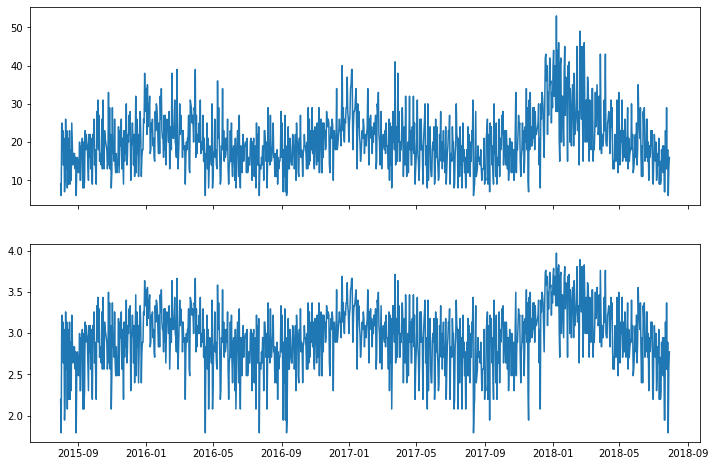

In [51]:
#compare original and logged data

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax[0].plot(admits)
ax[1].plot(admit_ln)

In [52]:
naive_model = auto_naive(train, seasonal_period=7)
naive_model

naive_preds = naive_model['model'].fit_predict(train_ln, horizon=len(test))
mean_absolute_error(naive_preds, test)

8.906122448979591

In [53]:
#ARIMA

#auto select via AIC
#arima_model = auto_arima(train_ln, m=7, suppress_warnings=True, 
#                         error_action="ignore")

arima_model = ARIMA(order=(3,1,2), seasonal_order=(1, 0, 1, 7), 
                    suppress_warnings=True)
arima_model.fit(train_ln)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1011
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -3094.316
Date:                             Mon, 10 Aug 2020   AIC                           6206.633
Time:                                     15:08:36   BIC                           6250.892
Sample:                                          0   HQIC                          6223.446
                                            - 1011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.385      0.700      -0.000       0.001
ar.L1         -0.5329      0.237     -2.246      0.025      -0.998      -0.068
ar.L2         -0.0831      0.041     -2.004      0.045      -0.164      -0.002
ar.L3         -0.1072      0.034     -3.124      0.002      -0.174      -0.040
ma.L1         -0.3604      0.240     -1.503      0.133      -0.830       0.110
ma.L2         -0.4181      0.215     -1.943      0.052      -0.840       0.004
ar.S.L7        0.9994      0.001   1757.398      0.000       0.998       1.000
ma.S.L7       -0.9724      0.010    -96.553      0.000      -0.992      -0.953
sigma2        25.7607      1.006     25.601      0.000      23.788      27.733
===================================================================================
Ljung-Box (Q):                       37.95   Jarque-Bera (JB):                29.98
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
h = 84
arima_forecast = arima_model.predict(n_periods=h, alpha=0.05, 
                                     return_conf_int=True)
arima_forecast = pd.concat([pd.DataFrame(arima_forecast[0]), 
                            pd.DataFrame(arima_forecast[1])], 
                            axis=1)
arima_forecast.columns=['mean', 'lower_95', 'upper_95']
idx = pd.date_range(start=train_ln.index[-1], periods=h+1, freq='D')[1:]
arima_forecast.index = idx

mean_absolute_error(arima_forecast['mean'], test)

8.20362130429438

In [61]:
#previous best Prophet

train_proph = prophet_formatted_df(train)

h = 84
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='England')
model.fit(train_proph)
future = model.make_future_dataframe(periods=h)
best_forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
#Prophet
train_proph = prophet_formatted_df(train_ln)

h = 84
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='England')
model.fit(train_proph)
future = model.make_future_dataframe(periods=h)
forecast_ln = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
mean_absolute_error(forecast_ln['yhat'].iloc[-h:], test_ln)

7.4343283378691325

/home/tom/anaconda3/envs/hds_forecast/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f5845a7aad0> has a label of '_ignore' which cannot be automatically added to the legend.


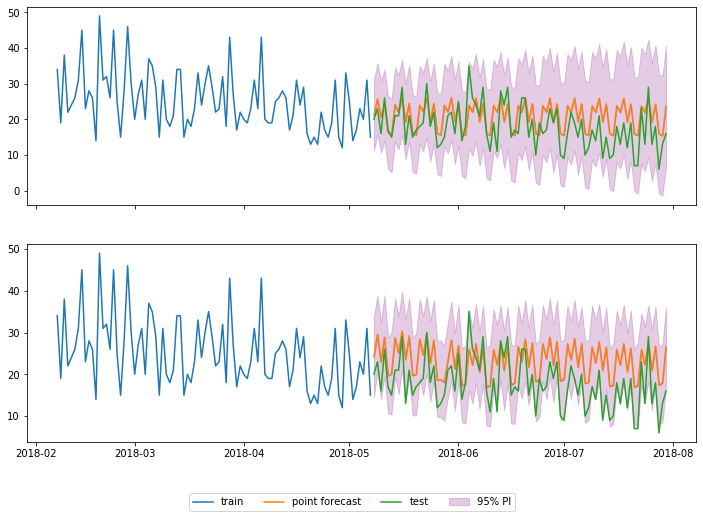

In [64]:
#plot the mean forecast and 95% prediction interval

#just predictions
f2 = forecast_ln[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-h:]
f2.index = f2['ds']
f2.index.freq = 'D'

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

#plot ARIMA
ax[0].plot(train_ln['resp_admits'].iloc[-90:])
ax[0].plot(arima_forecast['mean'])
ax[0].plot(test_ln['resp_admits'].iloc[:h])

ax[0].fill_between(arima_forecast.index, arima_forecast['mean'], 
                   arima_forecast['upper_95'],
                   alpha=0.2,
                   label='95% PI', color='purple');

ax[0].fill_between(arima_forecast.index, 
                  arima_forecast['mean'], 
                   arima_forecast['lower_95'],
                   alpha=0.2,
                   label='95% PI', color='purple');

#plot Prophet 
ax[1].plot(train_ln['resp_admits'].iloc[-90:])
ax[1].plot(f2['yhat'])
ax[1].plot(test_ln['resp_admits'].iloc[:h])

ax[1].fill_between(f2.index, f2['yhat'], f2['yhat_upper'],
                alpha=0.2,
                label='95% PI', color='purple');

ax[1].fill_between(f2.index, f2['yhat'], f2['yhat_lower'],
                alpha=0.2,
                label='95% PI', color='purple');


fig.legend(['train', 'point forecast', 'test', '_ignore', '95% PI'], 
           loc='lower center', ncol=4);

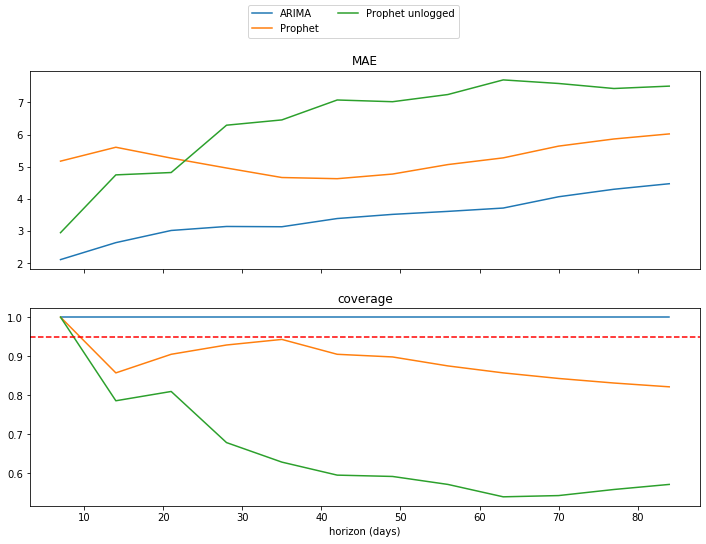

In [65]:
#calculate MAE and coverage at 7 days intervals during forecast period.
h = 84
horizons = [i for i in range(7, h+7, 7)]

f = forecast_ln[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-h:]
f.index = f['ds']
f.index.freq = 'D'

f3 = best_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-h:]
f3.index = f3['ds']
f3.index.freq = 'D'


arima_results = []
prophet_results = []
previous_best_results = []

arima_coverage = []
prophet_coverage = []
previous_best_coverage = []

for h in horizons:
    #mae
    
    #arima logged data
    m1_mae = mean_absolute_error(arima_forecast['mean'].iloc[:h], 
                                 test_ln['resp_admits'].iloc[:h])
    #prophet logged data
    m2_mae = mean_absolute_error(f['yhat'].iloc[:h], 
                                 test_ln['resp_admits'].iloc[:h])
    
    #from previous best model (unlogged data)
    m3_mae = mean_absolute_error(f3['yhat'].iloc[:h], 
                                 test['resp_admits'].iloc[:h])
    
    #coverage
    
    # arima logged
    m1_cov = coverage(test_ln['resp_admits'].iloc[:h], 
                      arima_forecast[['lower_95', 'upper_95']].iloc[:h].to_numpy())
    
    # prophet logged
    m2_cov = coverage(test_ln['resp_admits'].iloc[:h], 
                      f[['yhat_lower', 'yhat_upper']].iloc[:h].to_numpy())
    
    # prophet unlogged
    m3_cov = coverage(test['resp_admits'].iloc[:h], 
                      f3[['yhat_lower', 'yhat_upper']].iloc[:h].to_numpy())
    
    arima_results.append(m1_mae)
    prophet_results.append(m2_mae)
    previous_best_results.append(m3_mae)
    
    arima_coverage.append(m1_cov)
    prophet_coverage.append(m2_cov)
    previous_best_coverage.append(m3_cov)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(horizons, arima_results, label='ARIMA')
ax[0].plot(horizons, prophet_results, label='Prophet')
ax[0].plot(horizons, previous_best_results, label='Prophet unlogged data')

ax[0].set_title('MAE')

ax[1].plot(horizons, arima_coverage, label='ARIMA (logged data)')
ax[1].plot(horizons, prophet_coverage, label='Prophet (logged data)')
ax[1].plot(horizons, previous_best_coverage, label='Prophet unlogged data')
ax[1].axhline(y=0.95, color='r', linestyle='--')

ax[1].set_xlabel('horizon (days)')
ax[1].set_title('coverage')
fig.legend(['ARIMA', 'Prophet', 'Prophet unlogged'], 
           ncol=2, loc='upper center')

# Bonus Exercise 8: Cross-Validation

**Task**:
* Use time series cross validation to compare ARIMA, Prophet and the Naive model.